In [32]:
import pandas as pd 
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Project Name: Text Classification Using Deep Learning

#### Description
In this project, I'll take a set of articles labeled by topic, and build a model that classifies the category of a test set of articles separated from the training data.  
The model will be a **multilayered perceptron (MLP)**, which is a feed-forward neural network, to help predict article categories.
---
#### Table of Contents

1. **Preprocessing:**  
   1.1. We load the data and perform a **TF-IDF vectorization** of the articles.  
        - TF-IDF represents the weight of a certain word in a text relative to the number of documents the word has appeared across the corpus.  
   1.2. We turn the labels of the categories into **one-hot encodings** where each category gets its own position (index) in the vector.  
        - The position corresponding to the actual category is marked with `1`, and all others are `0`.  
   1.3. **Train-test split:** We split the data into train and test sets.

2. **Building the Network:**  
   - Build the neural network using **Keras** and fit it to the training data.

3. **Testing the Network:**  
   - Test the network on the test set and present the **confusion matrix**.


**Dataset:**  
The data used is from the website: [News Articles Categorization Dataset](https://huggingface.co/datasets/valurank/News_Articles_Categorization)


In [12]:
df = pd.read_csv('valurank_News_Articles_Categorization.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3722 entries, 0 to 3721
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3722 non-null   int64 
 1   Text        3722 non-null   object
 2   Category    3722 non-null   object
dtypes: int64(1), object(2)
memory usage: 87.4+ KB


In [13]:
# 1.1. We load the data and perform a Tf-idf vectorization of the articles
# Tf-idf represent the weight of a certain words in a text 
# relatively to the number of documents the word had appeared in in the corpus
# we take into account words that appear in maximum 90% of the articles and at least in two articles
# this ensures we leave only informative words

In [14]:
tfidf = TfidfVectorizer(max_df = 0.9, min_df = 2, stop_words='english') 

In [15]:
dtm = tfidf.fit_transform(df['Text'])

In [16]:
dtm.shape
# 3,722 articles with corpus size of 38,003 words

(3722, 38003)

In [17]:
# 1.2. We turn the labels of the categories to one-hot encodings where 
# each category gets its own position (index) in the vector.

In [18]:
df.Category.unique()

array(['Entertainment', 'science', 'Health', 'Politics', 'Sports',
       'World', 'Tech', 'Business'], dtype=object)

In [19]:
topic_map = {0:'Politics',1:'Sports',2:'Business',3:'World',4:'Health',5:'science',6:'Tech',7:'Entertainment'}
topic_map = {v: k for k, v in topic_map.items()}

In [20]:
# here we map the article topics first to ints according to our dictionary 
# and then to vectors of one-hot encodings as presented below 
df['label'] = df['Category'].map(topic_map)
y = to_categorical(df['label'])
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [21]:
# we get 3722 vectors with 8 indices each
y.shape

(3722, 8)

In [22]:
# 1.3. Train test split: we split the data, the test set is 33% of the data
X_train, X_test, y_train, y_test = train_test_split(dtm, y, test_size=0.33, random_state=42)

In [23]:
# we convert the sparse martices of the Tf-idf to full np arrays for our model
X_train_dense = X_train.toarray()
X_test_dense   = X_test.toarray()  

In [24]:
# 2. building the network using keras, and fitting it to the traning data
# the network
#layers
# - includes two dense layers of relu (rectified linear unit) neurons 
# -  end with a soft max function that will predict the category 
# it returns a vector of probabilities of how likely an article belongs to each category
# - the loss function we use is categorical cross entropy   

# Size
# since each Tf-idf vector of a document has a large n of indices (38,003) 
# we use a large number of neurons in the first and second layers (1,024, 512) 
# additionally, we use drop out, deactivating random neurons in each epoch to avoid overfitting

In [25]:
model = Sequential()
model.add(Dense(1024, input_dim=38003, activation='relu'))
model.add(Dropout(0.5))  # randomly drop 50% of neurons
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))
model.compile(loss = 'categorical_crossentropy',optimizer ='adam', metrics=['accuracy'])

In [26]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              38916096  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 39,445,000
Trainable params: 39,445,000
Non-trainable params: 0
_________________________________________________________________


In [27]:
# we fit the model
#model.fit(X_train_dense, y_train, epochs=20, batch_size=32, verbose=2)
# you can load my pre trained model here:

model = load_model("my_text_mlp_model.h5")

In [28]:
# Get predicted probabilities for each class
pred_probs = model.predict(X_test_dense)

# Convert probabilities to predicted class indices
predictions = pred_probs.argmax(axis=1)  # index of the max probability per sample

39/39 [==============================] - 4s 78ms/step


In [29]:
#Here we convert the predicted one-hot vectors back to categories 
y_test = y_test.argmax(axis = 1) # the index with the 1 is the category

topic_map = {0:'Politics',1:'Sports',2:'Business',3:'World',
             4:'Health',5:'science',6:'Tech',7:'Entertainment'}

y_test_topics = np.array([topic_map[i] for i in y_test])
predictions_topics = np.array([topic_map[i] for i in predictions])

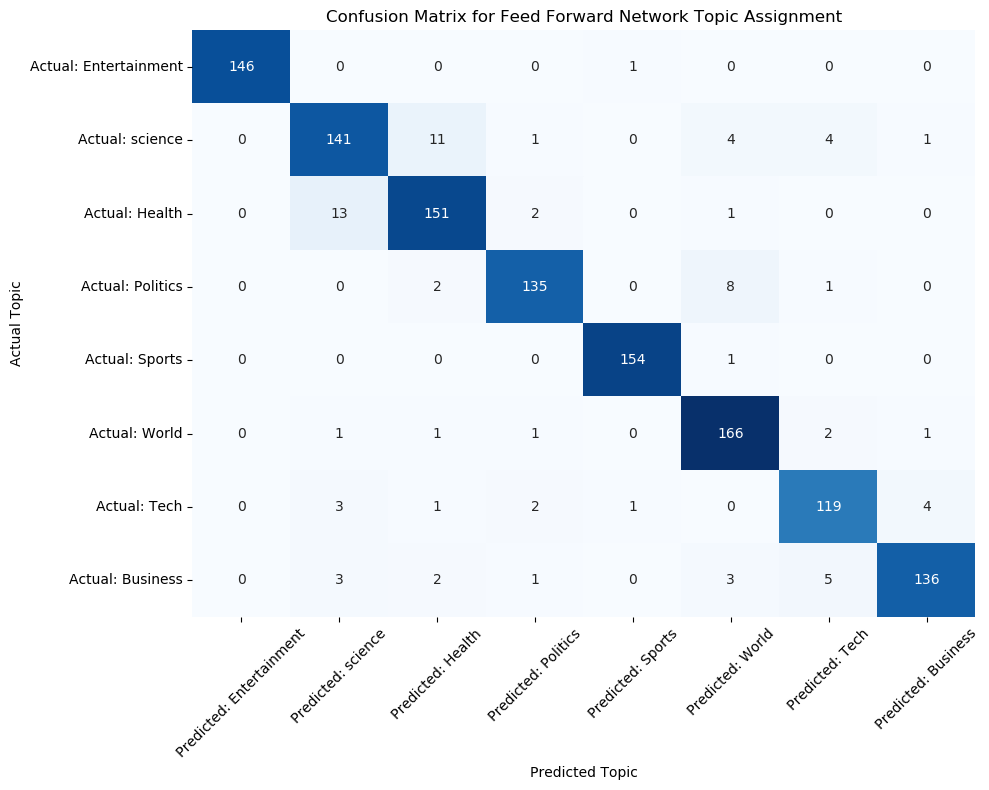

📊 Classification Report:

               precision    recall  f1-score   support

Entertainment       1.00      0.99      1.00       147
      science       0.88      0.87      0.87       162
       Health       0.90      0.90      0.90       167
     Politics       0.95      0.92      0.94       146
       Sports       0.99      0.99      0.99       155
        World       0.91      0.97      0.94       172
         Tech       0.91      0.92      0.91       130
     Business       0.96      0.91      0.93       150

    micro avg       0.93      0.93      0.93      1229
    macro avg       0.94      0.93      0.93      1229
 weighted avg       0.93      0.93      0.93      1229



In [30]:
# Get list of all unique topics from both columns
all_topics = df['Category'].unique()

# Generate confusion matrix 
cm = confusion_matrix(y_test_topics, predictions_topics, labels=all_topics)

# Create DataFrame for heatmap
cm_df = pd.DataFrame(cm,
                     index=[f"Actual: {label}" for label in all_topics],
                     columns=[f"Predicted: {label}" for label in all_topics])

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix for Feed Forward Network Topic Assignment")
plt.ylabel("Actual Topic")
plt.xlabel("Predicted Topic")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Classification report
print("📊 Classification Report:\n")
print(classification_report(y_test_topics, predictions_topics, labels=all_topics, target_names=all_topics))


In [ ]:

# The model performed worst in science and health, confusing the categories since that they are inherently very similar
# performance was good in the other categories